In [1]:
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
n_eval_trials = 1
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trial_groups = int(np.floor(10 / n_eval_trials))
n_trials = n_trial_groups * n_eval_trials


# Initialize dicts.
report = {}


model_names = [
    "icassp-convnet",
    "pcen-convnet",
    "pcen-convnet_aug-all",
    "pcen-add-convnet_aug-all-but-noise",
    #"pcen-addntt-convnet_aug-all-but-noise",
    #"pcen-ntt-convnet_aug-all-but-noise",
    "icassp-convnet_aug-all",
]

# Loop over augmentations.
for model_name in model_names:

    # Initialize dictionaries
    aug_report = {
        "test-CV-AUPRC": {},
        "test-CV-F": {},
        "val-AUPRC": {},
        "val-F": {},
    }

    ###############################   VALIDATION   #################################
    val_precisions = np.zeros((n_units, n_trials))
    val_recalls = np.zeros((n_units, n_trials))
    val_f1_scores = np.zeros((n_units, n_trials))
    val_auprcs = np.zeros((n_units, n_trials))
    val_thresholds = np.zeros((n_units, n_trials))
    val_threshold_ids = np.zeros((n_units, n_trials))


    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):

            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                val_p = np.zeros((n_thresholds,))
                val_r = np.zeros((n_thresholds,))
                val_f = np.zeros((n_thresholds,))
                val_threshold_id = 0
                val_auprc = 0.0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                val_threshold_id = np.argmax(val_f)
                val_p_ = np.array([1.0] + list(val_p) + [0.0])
                val_r_ = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

            val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
            val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
            val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
            val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
            val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
            val_auprcs[test_unit_id, trial_id] = val_auprc


    val_F_tensor = np.reshape(val_f1_scores, (6, n_eval_trials, n_trial_groups))
    val_F_trials = np.zeros((6, n_eval_trials))
    val_F_precisions = np.zeros((6, n_eval_trials))
    val_F_recalls = np.zeros((6, n_eval_trials))
    val_F_f1_scores = np.zeros((6, n_eval_trials))
    val_F_thresholds = np.zeros((6, n_eval_trials))
    val_F_threshold_ids = np.zeros((6, n_eval_trials))
    val_F_auprcs = np.zeros((6, n_eval_trials))


    val_AUPRC_tensor = np.reshape(val_auprcs, (6, n_eval_trials, n_trial_groups))
    val_AUPRC_trials = np.zeros((6, n_eval_trials))
    val_AUPRC_precisions = np.zeros((6, n_eval_trials))
    val_AUPRC_recalls = np.zeros((6, n_eval_trials))
    val_AUPRC_f1_scores = np.zeros((6, n_eval_trials))
    val_AUPRC_thresholds = np.zeros((6, n_eval_trials))
    val_AUPRC_threshold_ids = np.zeros((6, n_eval_trials))
    val_AUPRC_auprcs = np.zeros((6, n_eval_trials))


    # Select best n INDEPENDENT trials out of 10.
    # We proceed by groups to guarantee statistical independence.
    # Loop over test units.
    for test_unit_id in range(6):

        # Loop over trials.
        for eval_trial_id in range(n_eval_trials):

            best_F_column_id = np.argmax(
                val_F_tensor[test_unit_id, eval_trial_id, :])
            trial_F_id = n_trial_groups * eval_trial_id + best_F_column_id
            
            val_F_precisions[test_unit_id, eval_trial_id] =\
                val_precisions[test_unit_id, trial_F_id]
            val_F_recalls[test_unit_id, eval_trial_id] =\
                val_recalls[test_unit_id, trial_F_id]
            val_F_f1_scores[test_unit_id, eval_trial_id] =\
                val_f1_scores[test_unit_id, trial_F_id]
            val_F_trials[test_unit_id, eval_trial_id] =\
                trial_F_id
            val_F_thresholds[test_unit_id, eval_trial_id] =\
                val_thresholds[test_unit_id, trial_F_id]
            val_F_threshold_ids[test_unit_id, eval_trial_id] =\
                val_threshold_ids[test_unit_id, trial_F_id]
            val_F_auprcs[test_unit_id, eval_trial_id] =\
                val_auprcs[test_unit_id, trial_F_id]

            best_AUPRC_column_id = np.argmax(
                val_AUPRC_tensor[test_unit_id, eval_trial_id, :])
            trial_AUPRC_id = n_trial_groups * eval_trial_id + best_AUPRC_column_id
            
            val_AUPRC_precisions[test_unit_id, eval_trial_id] =\
                val_precisions[test_unit_id, trial_AUPRC_id]
            val_AUPRC_recalls[test_unit_id, eval_trial_id] =\
                val_recalls[test_unit_id, trial_AUPRC_id]
            val_AUPRC_f1_scores[test_unit_id, eval_trial_id] =\
                val_f1_scores[test_unit_id, trial_AUPRC_id]
            val_AUPRC_trials[test_unit_id, eval_trial_id] =\
                trial_AUPRC_id
            val_AUPRC_thresholds[test_unit_id, eval_trial_id] =\
                val_thresholds[test_unit_id, trial_AUPRC_id]
            val_AUPRC_threshold_ids[test_unit_id, eval_trial_id] =\
                val_threshold_ids[test_unit_id, trial_AUPRC_id]
            val_AUPRC_auprcs[test_unit_id, eval_trial_id] =\
                val_auprcs[test_unit_id, trial_AUPRC_id]


    aug_report["val-F"] = {
        "P": val_F_precisions,
        "R": val_F_recalls,
        "F": val_F_f1_scores,
        "trials": val_F_trials,
        "thresholds": val_F_thresholds,
        "threshold_ids": val_F_threshold_ids,
        "AUPRC": val_F_auprcs
    }


    aug_report["val-AUPRC"] = {
        "P": val_AUPRC_precisions,
        "R": val_AUPRC_recalls,
        "F": val_AUPRC_f1_scores,
        "trials": val_AUPRC_trials,
        "thresholds": val_AUPRC_thresholds,
        "threshold_ids": val_AUPRC_threshold_ids,
        "AUPRC": val_AUPRC_auprcs
    }


    ###############################   TEST   #################################

    for mode in ["F", "AUPRC"]:
        val_mode = "val-" + mode
        test_mode = "test-CV-" + mode

        aug_report[test_mode] = {
            "CV-P": np.zeros((n_eval_trials,)),
            "CV-R": np.zeros((n_eval_trials,)),
            "CV-F": np.zeros((n_eval_trials,)),
            "CV-AUPRC": np.zeros((n_eval_trials,)),
            "P": np.zeros((n_thresholds, n_eval_trials)),
            "R": np.zeros((n_thresholds, n_eval_trials)),
            "F": np.zeros((n_thresholds, n_eval_trials))
        }

        # Loop over trials.
        for eval_trial_id in range(n_eval_trials):
            break_switch = False

            test_tp = np.zeros((n_thresholds,))
            test_fp = np.zeros((n_thresholds,))
            test_fn = np.zeros((n_thresholds,))

            for test_unit_id in range(n_units):

                test_unit_str = units[test_unit_id]
                test_unit_dir = os.path.join(model_dir, test_unit_str)

                trial_id = int(aug_report[
                    val_mode]["trials"][test_unit_id, eval_trial_id])
                trial_str = "trial-" + str(trial_id)
                trial_dir = os.path.join(test_unit_dir, trial_str)

                # Load test predictions.
                test_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + test_unit_str,
                    "full-audio-metrics.csv"
                ])
                test_metrics_path = os.path.join(trial_dir, test_metrics_name)
                try:
                    test_metrics_df = pd.read_csv(test_metrics_path)
                    test_tp = test_tp + np.array(test_metrics_df["True positives"])
                    test_fp = test_fp + np.array(test_metrics_df["False positives"])
                    test_fn = test_fn + np.array(test_metrics_df["False negatives"])
                except:
                    print(test_metrics_name)
                    break_switch = True


            if break_switch:
                test_auprc = 0.0
                test_p = np.zeros((n_thresholds,))
                test_r = np.zeros((n_thresholds,))
                test_f = np.zeros((n_thresholds,))
                test_threshold = 1.0
                test_threshold_id = 0
                test_auprc = 0.0
            else:
                test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
                test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
                test_f = 2*test_p*test_r / (np.finfo(float).eps+(test_p+test_r))
                test_threshold = aug_report[
                    val_mode]["thresholds"][test_unit_id, eval_trial_id]
                test_threshold_id = int(aug_report[
                    val_mode]["threshold_ids"][test_unit_id, eval_trial_id])
                test_p_ = np.array([1.0] + list(test_p) + [0.0])
                test_r_ = np.array([0.0] + list(test_r) + [1.0])
                test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)



            aug_report[test_mode]["CV-P"][eval_trial_id] = test_p[test_threshold_id]
            aug_report[test_mode]["CV-R"][eval_trial_id] = test_r[test_threshold_id]
            aug_report[test_mode]["CV-F"][eval_trial_id] = test_f[test_threshold_id]
            aug_report[test_mode]["CV-AUPRC"][eval_trial_id] = test_auprc


            aug_report[test_mode]["P"][:, eval_trial_id] = test_p
            aug_report[test_mode]["R"][:, eval_trial_id] = test_r
            aug_report[test_mode]["F"][:, eval_trial_id] = test_f
            

        all_test_recalls = np.array(list(np.sort(np.ravel(aug_report[test_mode]["R"]))))
        interpolated_precisions = np.zeros((2 + len(all_test_recalls), n_eval_trials))

        for eval_trial_id in range(n_eval_trials):
            precision_interpolator = scipy.interpolate.interp1d(
                np.array([0.0] + list(aug_report[test_mode]["R"][:, eval_trial_id]) + [1.0]),
                np.array([1.0] + list(aug_report[test_mode]["P"][:, eval_trial_id]) + [0.0]))
            interpolated_precisions[:, eval_trial_id] =\
                np.array([1.0] + list(precision_interpolator(all_test_recalls)) + [0.0])

        interpolated_recalls = np.array([0.0] + list(all_test_recalls) + [1.0])
        aug_report[test_mode]["interpolated_P"] = np.sort(interpolated_precisions, axis=1)
        aug_report[test_mode]["interpolated_R"] = interpolated_recalls
        aug_report[test_mode]["interpolated_F"] =\
            (2*aug_report[test_mode]["interpolated_P"]*aug_report[test_mode]["interpolated_R"][:, np.newaxis]) /\
            (np.finfo(float).eps+aug_report[test_mode]["interpolated_P"]+aug_report[test_mode]["interpolated_R"][:, np.newaxis])
            

    report[model_name] = aug_report


In [2]:
## SPECTRAL FLUX
import h5py
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import sys
sys.path.append('../src')
import localmodule
from tqdm import tqdm

# Define directory of spectral flux ODFs.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
units = localmodule.get_units()
n_units = len(units)
sf_dir = os.path.join(data_dir,
    "_".join([dataset_name, "spectral-flux"]))


# Define constants.
sf_sr = 22050
sf_hop_length = 512
n_thresholds = 100
min_dist = 4
tolerance = 0.5


# Define array of thresholds.
thresholds = np.linspace(0.0, 0.5, n_thresholds)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))


In [ ]:
# Loop over units.
for unit_id, unit_str in enumerate(units):

    # Load onset detection function.
    odf_path = os.path.join(sf_dir, unit_str + ".hdf5")
    odf_file = h5py.File(odf_path, "r")
    odf = odf_file["spectral-flux_odf"].value
    odf = np.ravel(odf)
    odf_file.close()

    # Load annotation.
    annotation_path = os.path.join(
        annotations_dir, unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)

    # Loop over thresholds.
    for th_id, threshold in tqdm(enumerate(thresholds)):
        # Pick peaks.
        peak_locs = peakutils.indexes(
            odf, thres=threshold, min_dist=4)
        selected = peak_locs * sf_hop_length / sf_sr
        #print(len(selected), len(relevant))
        selected_relevant = mir_eval.util.match_events(
            relevant, selected, tolerance)
        #print(len(selected_relevant))
        
        true_positives = len(selected_relevant)
        n_selected = len(selected)
        false_positives = n_selected - true_positives
        false_negatives = n_relevant - true_positives

        tp_matrix[th_id, unit_id] = true_positives
        fp_matrix[th_id, unit_id] = false_positives
        fn_matrix[th_id, unit_id] = false_negatives
        
sf_total_tps = np.sum(tp_matrix, axis=1)
sf_total_fps = np.sum(fp_matrix, axis=1)
sf_total_fns = np.sum(fn_matrix, axis=1)

sf_total_precisions = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fps)
sf_total_precisions = sf_total_precisions[::-1]
sf_total_recalls = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fns)
sf_total_recalls = sf_total_recalls[::-1]
sf_total_f1_scores = (2*sf_total_precisions*sf_total_recalls) / (sf_total_precisions+sf_total_recalls)

sf_report = {
    "P": sf_total_precisions,
    "R": sf_total_recalls,
    "F": sf_total_f1_scores
}
report["spectral-flux"] = {"test": sf_report}

7it [00:00, 30.25it/s]

3 2936
0
3 2936
0
3 2936
0
3 2936
0
3 2936
0
4 2936
0
4 2936
0
5 2936
0


16it [00:00, 35.17it/s]

6 2936
0
6 2936
0
6 2936
0
6 2936
0
7 2936
0
9 2936
0
9 2936
0
10 2936
0
10 2936
0


25it [00:00, 36.83it/s]

10 2936
0
10 2936
0
10 2936
0
10 2936
0
10 2936
0
10 2936
0
10 2936
0
12 2936
1
12 2936
1


34it [00:00, 37.59it/s]

15 2936
1
16 2936
1
17 2936
1
17 2936
1
17 2936
1
17 2936
1
19 2936
1
19 2936
1
19 2936
1


42it [00:01, 37.84it/s]

19 2936
1
22 2936
1
23 2936
1
24 2936
1
27 2936
2
29 2936
2
34 2936
2
35 2936
2


50it [00:01, 37.96it/s]

37 2936
3
40 2936
3
42 2936
3
45 2936
3
51 2936
4
59 2936
6
71 2936
8
82 2936
11


58it [00:01, 37.61it/s]

92 2936
11
101 2936
12
120 2936
14
139 2936
14
166 2936
15
198 2936
17
243 2936
17
307 2936


62it [00:01, 36.53it/s]

21
404 2936
27
490 2936
35
606 2936
41
757 2936
46


66it [00:01, 33.30it/s]

924 2936
57
1150 2936
77
1405 2936
100
1784 2936
127
2334 2936


69it [00:02, 28.97it/s]

169
3183 2936
236
4712 2936
347
7348 2936
526
11956 2936


72it [00:03, 20.52it/s]

808
19691 2936
1231
32000 2936


74it [00:05, 12.86it/s]

1756
50688 2936
2301
76852 2936


76it [00:11,  6.85it/s]

2727
110045 2936


77it [00:15,  4.90it/s]

2898
146187 2936


78it [00:21,  3.57it/s]

2932
179866 2936


79it [00:29,  2.69it/s]

2936
206301 2936


80it [00:37,  2.11it/s]

2936
223900 2936


                                   Precision  Recall F1 score   AUPRC
icassp-convnet                        64.43%  65.43%   64.93%  66.31%
pcen-convnet                          58.55%  75.89%   66.10%  71.97%
pcen-convnet_aug-all                  59.73%  67.62%   63.43%  61.64%
pcen-add-convnet_aug-all-but-noise    50.66%  74.73%   60.39%  65.95%
icassp-convnet_aug-all                33.74%  75.17%   46.58%  56.06%


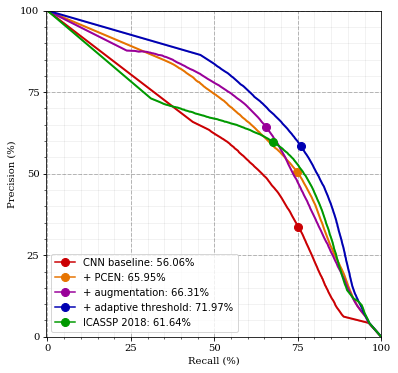

In [7]:
import matplotlib
from matplotlib import pyplot as plt
sorted_precisions = np.sort(interpolated_precisions, axis=1)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

model_names = [
    "icassp-convnet",
    "pcen-convnet",
    "pcen-convnet_aug-all",
    "pcen-add-convnet_aug-all-but-noise",
    #"pcen-addntt-convnet_aug-all-but-noise",
    #"pcen-ntt-convnet_aug-all-but-noise",
    "icassp-convnet_aug-all",
]

model_colors = [
    "#CB0003", 
    "#E67300",
    "#990099",
    "#0000B2",
    "#009900",
    '#008888',
    '#888800',
    '#555555',
]
model_legends = []

model_captions = {
    "icassp-convnet": "CNN baseline",
    "pcen-convnet": "+ PCEN",
    "pcen-convnet_aug-all": "+ augmentation",
    "pcen-add-convnet_aug-all-but-noise": "+ adaptive threshold",
    "pcen-addntt-convnet_aug-all-but-noise": "+ mixture of experts",
    "icassp-add-convnet_aug-all-but-noise": " - PCEN",
    "pcen-add-convnet_aug-all": "noisy main channel",
    "pcen-ntt-convnet_aug-all-but-noise": "NTT instead",
    "icassp-convnet_aug-all": "ICASSP 2018",
}

eval_mode = "test-CV-AUPRC"

for model_id, model_name in enumerate(model_names):
    
    model_color = model_colors[model_id]
    
    ax.fill_between(
        100 * report[model_name][eval_mode]["interpolated_R"],
        100 * np.percentile(report[model_name][eval_mode]["interpolated_P"], 25, axis=1),
        100 * np.percentile(report[model_name][eval_mode]["interpolated_P"], 75, axis=1),
        color = model_color,
        alpha = 0.2);

    ax.plot(
        100 * report[model_name][eval_mode]["interpolated_R"],
        100 * np.percentile(report[model_name][eval_mode]["interpolated_P"], 50, axis=1),
        color = model_color,
        linewidth = 2.0
    )
    
    cv_p = np.mean(report[model_name][eval_mode]["CV-P"])
    cv_r = np.mean(report[model_name][eval_mode]["CV-R"])
    cv_f = np.mean(report[model_name][eval_mode]["CV-F"])
    cv_auprc = np.mean(report[model_name][eval_mode]["CV-AUPRC"])
    
    plot_r = [100*cv_r]
    plot_p = [100*cv_p]
    plot_f = 100*cv_f
    plot_auprc = 100 * cv_auprc
    
    ax.plot(plot_r, plot_p, "o", 
            color=model_color,
            markersize=8.0)
    
    model_legend = matplotlib.lines.Line2D([], [], color=model_color, marker='o',
        markersize=8, label=model_captions[model_name] + ": {:5.2f}%".format(plot_auprc))
    model_legends.append(model_legend)

    
plt.legend(handles=model_legends)
    
    
############################### AXES AND GRID ###################################

major_ticks = np.linspace(0, 100, 5).astype("int")
minor_ticks = np.linspace(0, 100, 21).astype("int")

ax.set_xlim(-0.3, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(map(str, major_ticks), family="serif");
ax.set_xlabel("Recall (%)", family="serif");

ax.set_ylim(0.0, 100)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_yticklabels(map(str, major_ticks), family="serif");
ax.set_ylabel("Precision (%)", family="serif");

ax.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax.set_axisbelow(True)

plt.savefig("spl_fig_precision-recall.png", dpi=500, bbox_inches="tight")
plt.savefig("spl_fig_precision-recall.pdf", bbox_inches="tight")


############################### TABLE ###################################

Ps = ["{:5.2f}%".format(100*np.mean(report[x][eval_mode]["CV-P"])) for x in report]
Rs = ["{:5.2f}%".format(100*np.mean(report[x][eval_mode]["CV-R"])) for x in report]
F1s = ["{:5.2f}%".format(100*np.mean(report[x][eval_mode]["CV-F"])) for x in report]
AUCs = ["{:5.2f}%".format(100*np.mean(report[x][eval_mode]["CV-AUPRC"])) for x in report]
metrics = [Ps, Rs, F1s, AUCs]

import pandas as pd
print(pd.DataFrame([Ps, Rs, F1s, AUCs], columns=model_names,
             index=["Precision", "Recall", "F1 score", "AUPRC"]).T)

In [52]:
np.percentile(report[model_name][eval_mode]["interpolated_P"], 50, axis=1)

array([ 1.        ,  0.86860958,  0.86860958, ...,  0.04251161,
        0.04225437,  0.        ])

In [5]:
model_names = 

['pcen-convnet_aug-all',
 'pcen-add-convnet_aug-all-but-noise',
 'icassp-convnet_aug-all',
 'pcen-convnet',
 'icassp-convnet']

In [42]:
median_r
#report[model_name]["test-CV-AUPRC"]["CV-F"]

array([ 0.        ,  0.20377635,  0.20377635, ...,  0.96395812,
        0.96404279,  1.        ])

In [14]:
test_mode = "test-CV-AUPRC" 

Ps = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-P"])) for x in report]
Rs = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-R"])) for x in report]
F1s = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-F"])) for x in report]
AUCs = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-AUPRC"])) for x in report]
metrics = [Ps, Rs, F1s, AUCs]

import pandas as pd
pd.DataFrame([Ps, Rs, F1s, AUCs], columns=model_names,
             index=["Precision", "Recall", "F1 score", "AUPRC"]).T

,Precision,Recall,F1 score,AUPRC
icassp-convnet,43.90%,65.36%,52.27%,52.72%
pcen-convnet,23.04%,16.94%,19.53%,20.72%
pcen-convnet_aug-all,56.46%,63.91%,56.62%,61.31%
pcen-add-convnet_aug-all-but-noise,60.66%,75.64%,67.04%,72.46%
pcen-add-convnet_aug-all,58.20%,46.74%,49.17%,46.86%
icassp-convnet_aug-all,54.84%,69.42%,61.03%,60.59%


In [245]:
report["icassp-convnet"]["CV-AUPRC"]

KeyError: 'CV-AUPRC'

In [72]:


############################# PRINT RESULTS ###################################

print("CONVNET:      P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_cnn_p, 100*best_cnn_r, 100*best_cnn_f))
ax.text(100*best_cnn_r - 22.0 , 100*best_cnn_p - 9.0,
    "    convnet\n F = {:5.2f}%".format(100*best_cnn_f),
    color="#CB0003", fontsize=11.0, family="serif",
    backgroundcolor="white")


print("ICASSP 2018:  P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_augcnn_p, 100*best_augcnn_r, 100*best_augcnn_f))
ax.text(100*best_augcnn_r - 3, 100*best_augcnn_p + 5.0,
    " ICASSP 2018 \n  F = {:5.2f}%".format(100*best_augcnn_f),
    color="#990099", fontsize=11.0, family="serif",
    backgroundcolor="white")

print("AUG PCEN:     P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_pcenall_p, 100*best_pcenall_r, 100*best_pcenall_f))
ax.text(100*best_pcenall_r, 100*best_pcenall_p + 8.0,
    "     PCEN \nF = {:5.2f}%".format(100*best_pcenall_f),
    color="#E67300", fontsize=11.0, family="serif",
    backgroundcolor="white")

CONVNET:      P = 53.72%,  R = 54.82%,  F = 54.27%
ICASSP 2018:  P = 57.62%,  R = 68.78%,  F = 62.71%
AUG PCEN:     P = 64.30%,  R = 58.71%,  F = 61.38%
